In [1]:
import sys 
sys.path.append("..") 
import network_builder
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from networkx.algorithms import community

%matplotlib inline
%config InlineBackend.figure_format = "retina"


Bad key "text.kerning_factor" on line 4 in
/mounts/data/proj/yihong/newhome/ENTER/envs/concept-net/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# This file used the updated ngrams: ngrams that cannot include white space

## creating a directed graph based on FP and BP of all languages

We construct a ***directed*** graph
$$G_d = (V_d, E_d)$$ and  
$$l_d: E_d \rightarrow \text{set(langs)}$$ and  
$$ngram: E_d \times l_d(e) \rightarrow \text{set(ngrams)}$$
where $V_d$ are the English concepts (lemmata or ngrams or phrases),  
$E_d$ are the directed edges linking between concepts,  
$l_d$ represents an edge mapping function (the languages having this relation).   
$ngram$ represents an edge x language mapping function (the ngrams in that language results in the relation).
 
Let $f \in F$ be a focal concept from the intial focal cencept set $F$,  
and $\textit{Conceptualizer} = BP(FP(\cdot))$ which proposes related concepts,  
where $FP(\cdot)$ proposes associated ***target-language*** ngrams  
and $BP(\cdot)$ proposes associated ***source-language*** concepts 

The graph construction is as follows: 

$V_d \leftarrow F$  
$E_d \leftarrow \emptyset$  

For each $f \in F$:  
for each $\text{lang}$ in $\text{langs}$:  

$\text{ngrams} = FP(f, \text{lang})$  
$C = BP(\text{ngrams})$ 

For each $c \in C$:  
$V_d \leftarrow V_d \cup \{c\}$ if $c \notin V_d$  
$E_d \leftarrow E_d \cup \{<f, c>\}$  
$l_d(<f, c>) \leftarrow l_d(<f, c>) \cup \text{lang}$  
$ngram(<f, c>, \text{lang}) \leftarrow \text{ngrams}$

In [3]:
# we first build a DIRECTED graph
# which is the base of other UNDIRECTED graphs to be constructed
considered_lang = 'all'
# load from disk
net = network_builder.ConceptNetwork(involved_lang=considered_lang, 
                                     load_directed_graph_from_path=True, use_updated=True,
                                     load_directed_graph_path= \
                                     '/mounts/data/proj/yihong/newhome/ConceptNetwork/network_related/stored_networks')



Loading directed net from /mounts/data/proj/yihong/newhome/ConceptNetwork/network_related/stored_networks/directed_network_updated.pickle ...


In [4]:
print(f"Number of nodes: {net.concept_net.number_of_nodes()}")
print(f"Number of edges: {net.concept_net.number_of_edges()}")

# Number of nodes: 5870
# Number of edges: 1161424

Number of nodes: 5870
Number of edges: 1161424


## creating an undirected graph based on the directed graph

Our conceptualizer does not really distinguish **colexification(polysemy/homonymy)**, **partial colexification**, **semantic vagueness** (either in source language side or target side) or **in-context cooccurrences**. Therefore the network constructed does not always represent how the concepts are related in terms of puere **cross-lingual polysemy**. Nevertheless, the edges between two concepts do show that strong associations are present cross-lingually (we do not differentiate the reasons behind those associations).

We construct an ***undirected*** graph
$$G_u = (V_u, E_u)$$ and  
$$w: E_u \rightarrow \mathbb{Z}_{+}$$  
where $V_u$ are the English concepts (lemmata or ngrams or phrases),  
$E_u$ are the undirected edges linking between concepts,   
$w$ represents an edge weighting function (the number of languages having this relation).   


The graph construction is as follows: 

$V_u \leftarrow V_d$  
$E_u \leftarrow \emptyset$  

for $e \in E_d$:  
$<u, v> = e$  

if $u == v$:  

$E_u \leftarrow E_u \cup (u, u)$  
$w((u, v)) = \text{COUNT}(l_u(<u, u>))$   

else:  

if $<v, u> \in E_d$:  
$w((u, v)) = \text{COUNT}(l_d(<u, v>) \cup l_d(<v, u>))$  
else:  
$w((u, v)) = \text{COUNT}(l_d(<u, v>))$  

$E_u \leftarrow E_u \cup (u, v)$  

\# Post-processing  
for $e \in E_u$:  
remove $e$ if $w((u, v)) < \theta$

for $v \in V_u$:  
remove $v$ if $\text{degree}(v) == 0$

All concepts form a huge network of **human perceptualizations of the world**, each language forms a subnetwork which is a realization of how those concepts are related in the thoughts of those who speak that language. 

We human beings have more or less similar perceptualization of most concepts, therefore some associations in some concepts (through metonymy, metaphor, meaning extensions etc.) are present in a lot of languages. That is also why we human beings can understand each other and learn new languages: ***adding new concepts and building new edges between existing concepts***.

As we are considering as many as languages as possible, we are *revealing the global associations among concepts across a huge amount of languages*.

In [5]:
# we tried with different threshold (minimum languages of a node/edge)
# to filter some less trustable or possibly problematic nodes/edges 
# due to misalignment or noise of the source data

# for num in [1, 5, 10, 20, 50, 100]:
#     print(f"Undirected Net - {num}: ")
#     undirected_net = net.to_undirected(aggregate_type='union', minimum_number_of_langs=num)
#     print(f"Number of nodes: {undirected_net.number_of_nodes()}")
#     print(f"Number of edges: {undirected_net.number_of_edges()}")
#     print(f"Average degree: {undirected_net.number_of_edges() / undirected_net.number_of_nodes()}")
#     print(f"Connected network : {nx.is_connected(undirected_net)}")
#     print(f"Number of connected components: {nx.number_connected_components(undirected_net)}")
#     print()

# Undirected Net - 1: 
# Number of nodes: 5870
# Number of edges: 1000937
# Average degree: 170.5173764906303
# Connected network : True
# Number of connected components: 1

# Undirected Net - 5: 
# Number of nodes: 4028
# Number of edges: 122798
# Average degree: 30.48609731876862
# Connected network : True
# Number of connected components: 1

# Undirected Net - 10: 
# Number of nodes: 3562
# Number of edges: 58031
# Average degree: 16.291690061763056
# Connected network : True
# Number of connected components: 1

# Undirected Net - 20: 
# Number of nodes: 3133
# Number of edges: 30175
# Average degree: 9.631343759974465
# Connected network : False
# Number of connected components: 2

# Undirected Net - 50: 
# Number of nodes: 2591
# Number of edges: 13607
# Average degree: 5.2516402933230415
# Connected network : False
# Number of connected components: 9

# Undirected Net - 100: 
# Number of nodes: 2221
# Number of edges: 7634
# Average degree: 3.4371904547501124
# Connected network : False
# Number of connected components: 60

comment out
<!-- |filterer type | Edges | Edges |  Average degree | Connected network | Number of connected components |  
| --- | --- | --- | --- | --- | --- |  
|- 1|5745|935696|162.87|True|1|  
|- 5|3839|97310|25.35|True|1|  
|- 10|3408|41007|12.03|True|1|  
|- 20|2970|20416|6.87|False|2|  
|- 50|2450|9274|3.79|False|39|  
|- 100|2135|5478|2.57|False|198|   -->

## we analyze the network with threshold of 50 in the following

In [6]:
# this is a SPARSE graph, i.e., #edges << O(n^2)
undirected_net = net.to_undirected(aggregate_type='union', minimum_number_of_langs=50)

### Centrality

In [7]:
# degree centrality: reflecting the degrees of each node
degree_centrality = nx.degree_centrality(undirected_net)
# betweenness centrality: reflecting the nodes that control the flow (bridges)
betweenness_centrality = nx.betweenness_centrality(undirected_net)
# closeness centrality: reflecting the "closeness" of a node to other nodes
"""
The closeness centrality is normalized to (n-1)/(|G|-1) 
where n is the number of nodes in the connected part of graph containing the node. 
If the graph is not completely connected, 
this algorithm computes the closeness centrality 
for each connected part separately scaled by that parts size.
"""
closeness_centrality = nx.closeness_centrality(undirected_net)

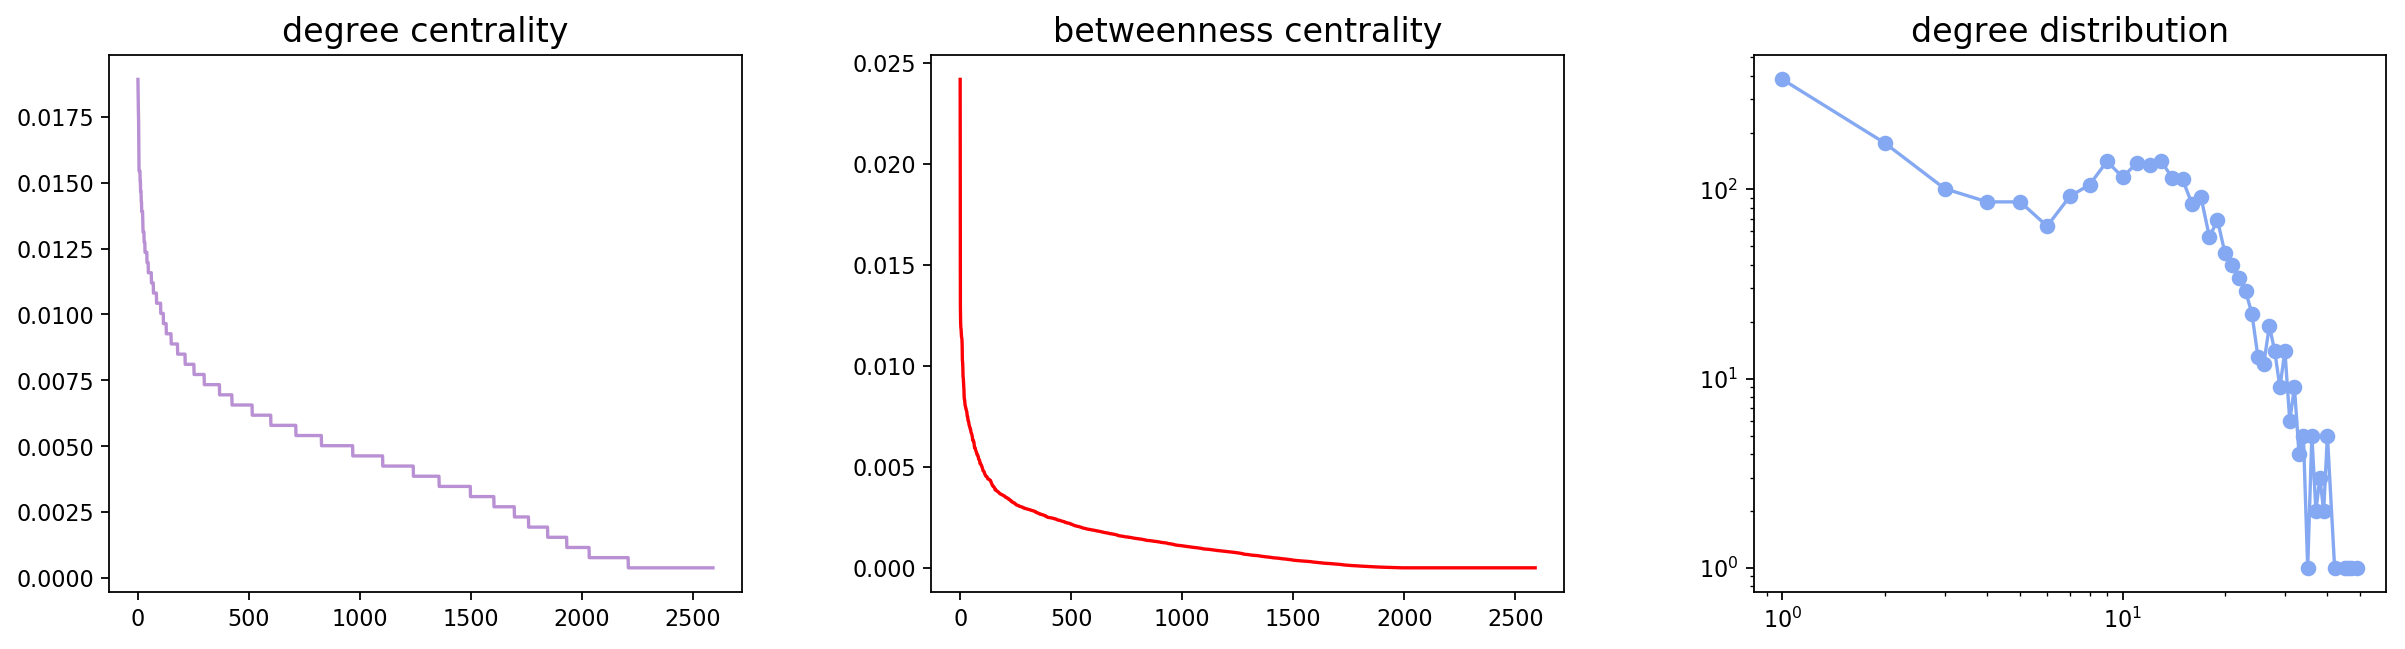

In [8]:
plt.figure(figsize=(15, 4), dpi=80)
plt.subplot(1, 3, 1)
plt.plot(sorted([x[1] for x in degree_centrality.items()], reverse=True), color=[185/255, 144/255, 212/255])
plt.title("degree centrality", fontsize=15)

plt.subplot(1, 3, 2)
plt.plot(sorted([x[1] for x in betweenness_centrality.items()], reverse=True), color=[252/255, 0/255, 6/255])
plt.title("betweenness centrality", fontsize=15)

plt.subplot(1, 3, 3)
degs = defaultdict(int)
for i in list(dict(undirected_net.degree()).values()): degs[i]+=1
items = sorted(degs.items())
x, y = np.array(items).T
y_sum = np.sum(y)
plt.plot(x, y, 'b-o', color=[132/255, 168/255, 241/255])
plt.xscale('log')
plt.yscale('log')
# plt.legend(['Degree'])
# plt.xlabel('$K$', fontsize=20)
# plt.ylabel('$P(K)$', fontsize=20)
plt.title('degree distribution', fontsize=15)

# plt.subplot(1, 3, 3)
# plt.plot(sorted([x[1] for x in closeness_centrality.items()], reverse=True), color='g')
# plt.title("closeness centrality")
plt.tight_layout(pad=0.5)
plt.subplots_adjust(wspace=0.3, hspace=10)
plt.savefig("small_world.pdf", dpi=300)
plt.show()

# the degree centrality and betweenness centraility indicates that 
# only a few nodes that have high degrees / containing bridge edges
# those nodes should be very important

# the closeness centrality might not be very interesting to us

### Analyzing Connected Components

In [9]:
components = [undirected_net.subgraph(c).copy() for c in nx.connected_components(undirected_net)]

In [10]:
largest_component = None
max_num = -1
nodes_num = defaultdict(int)
for c in components: 
    nodes_num[c.number_of_nodes()] += 1
    if c.number_of_nodes() > max_num:
        largest_component = c
        max_num = c.number_of_nodes()

nodes_num = sorted(nodes_num.items(), key=lambda x : x[0], reverse=False)
for k, v in nodes_num:
    print(f"Containing {k} nodes: {v}")
# there is one single big connected component
# Containing 1 nodes: 36
# Containing 2 nodes: 2
# Containing 2410 nodes: 1

Containing 1 nodes: 6
Containing 2 nodes: 2
Containing 2581 nodes: 1


In [11]:
# Let's see what is in each component
# 1
for c in components:
    if c.number_of_nodes() == 1:
        print(c.nodes)

['$aaron$']
['$iscariot$']
['$jesse$']
['$troas$']
['$gaius$']
['$log$']


In [12]:
# 2
for c in components:
    if c.number_of_nodes() == 2:
        print(c.nodes)

['$short$', '$shorten$']
['$alexander$', '$alexandrian$']


In [13]:
# we would like to then further analyze the largest component
print(f"Number of nodes: {largest_component.number_of_nodes()}")
print(f"Ratio: {largest_component.number_of_nodes() / undirected_net.number_of_nodes()}")
# the largest component contains 2968 concepts which covers 97% concepts of the ConceptNet

Number of nodes: 2581
Ratio: 0.9961404862987263


In [14]:
# # average_shortest_path_length / characteristic path length
# p = nx.average_shortest_path_length(largest_component)

# # diameter
# d = nx.diameter(largest_component)

# # average_clustering_coefficient
# a = nx.average_clustering(largest_component)

# print(f"Characteristic path length: {p}")
# print(f"Diameter: {d}")
# print(f"Average clustering: {a}")

# the values shows the larget component is actually forming a **small-world** phenomenon

# Characteristic path length: 4.21080045292222
# Diameter: 9
# Average clustering: 0.26221253000728967

### Communities

In [15]:
# Analyzing the community structure of cross-linguistic polysemy networks should
# give us some interesting insights into general concept relations. 
# network nodes are tightly connected in knit groups within communities and loosely connected between communities.
import community as community_louvain
# Louvain Community Detection Algorithm 
# in Fast unfolding of communities in large networks
# by Blondel, Vincent D., et al.
# pip install from here: https://github.com/taynaud/python-louvain
partition = community_louvain.best_partition(undirected_net, resolution=0.1, random_state=114514)

In [16]:
partition_dict = {}
for k, v in partition.items():
    if v not in partition_dict:
        partition_dict[v] = {k}
    else:
        partition_dict[v].add(k)

In [17]:
print(f"Number of communities: {len(partition_dict)}")

Number of communities: 288


In [18]:
for p, nodes in sorted(partition_dict.items(), key=lambda x: x[0], reverse=False):
    if len(nodes) >= 10:
        print(f"{p}: {nodes}")

3: {'$gift$', '$treasury$', '$something$', '$sacrifice$', '$altar$', '$arrangement$', '$relate$', '$offer$', '$offering$', '$yea$', '$give$', '$lepton$', '$jabesh$', '$propitiation$'}
5: {'$reprobate$', '$testing$', '$acceptable$', '$blessed$', '$joyful$', '$skip$', '$acceptance$', '$approve$', '$prove$', '$gladness$', '$test$', '$pleasing$', '$temptation$', '$trial$', '$exult$', '$rejoice$', '$please$', '$pleased$', '$desire$', '$try$', '$delight$', '$gladly$', '$glad$', '$leap$', '$joy$', '$pleasure$', '$tempt$', '$attempt$', '$proving$'}
6: {'$length$', '$garment$', '$put$', '$cloak$', '$veil$', '$sackcloth$', '$clothing$', '$screen$', '$snow$', '$gird$', '$wear$', '$flour$', '$naked$', '$sheet$', '$breastplate$', '$belt$', '$shave$', '$dress$', '$linen$', '$tunic$', '$bright$', '$robe$', '$purple$', '$splendid$', '$mantle$', '$wrap$', '$handkerchief$', '$cloth$', '$wide$', '$hair$', '$white$', '$clothe$', '$nakedness$', '$fine$', '$whiten$', '$chorazin$'}
8: {'$widow$', '$handmaid$

### In the following, we want to list some example communities that might be interesting to us

(I just looked at the first 50 communities)
3: relate to "offer"
6: relate to "clothes"


In [19]:
# a function to visualize 

def draw_graph(graph, node_size=10, node_color='steelblue', edge_color='darkkhaki', edge_width=2,
               use_different_widths=False, font_family='serif', font_size=2,
               include_labels=True, maximum_edge_width_multiplier=5, save_path=None):
    pos = nx.spring_layout(graph)
    node_sizes = [node_size for _ in graph.nodes]
    node_colors = [node_color for _ in graph.nodes]
    edge_colors = [edge_color for _ in graph.edges]

    # use different widths for edges with different number of languages / language families
    if use_different_widths:
        max_language = max([len(graph.edges[e]['lang']) for e in graph.edges()])
        # set the width of an edge with the most languages to be edge_width * 5
        # and set the minimum width to be edge_width
        edge_widths = [min(edge_width*maximum_edge_width_multiplier,
                       max([len(graph.edges[e]['lang'])*5/max_language, edge_width])) for e in graph.edges()]
    else:
        edge_widths = [edge_width for _ in graph.edges]

    nx.draw_networkx_nodes(graph, pos=pos, node_size=node_sizes, alpha=0.8, node_color=node_colors)
    nx.draw_networkx_edges(graph, pos=pos, edgelist=graph.edges, width=edge_widths, alpha=0.8, edge_color=edge_colors)
    if include_labels:
        labels = {node: graph.nodes[node]['name'].replace('$', '\$') for node in graph.nodes}
        nx.draw_networkx_labels(graph, pos=pos, labels=labels, font_family=font_family, font_size=font_size, alpha=0.8)
    plt.tight_layout(pad=0.5)
    ax = plt.gca()
#     ax.axes.xaxis.set_visible(False)
#     ax.axes.yaxis.set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False) 
    ax.spines['bottom'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.05, right=0.95)
    if save_path is not None:
        plt.savefig(save_path, dpi=300, pad_inches=0.1, bbox_inches='tight')
#     plt.show()
    
def draw_community(community_index, partition_dictionary, graph, save_path=None):
    temp_graph = graph.subgraph(partition_dictionary[community_index])
    draw_graph(temp_graph, node_size=1, font_size=9, edge_width=1, use_different_widths=True, save_path=save_path,
                               node_color=[185/255, 144/255, 212/255], edge_color=[132/255, 168/255, 241/255])

In [20]:
# As most of the communities are meaningful cluster of concepts, to facilitate,
# we might be more interested in LARGE communites
# in the following we visualize communites with more than 10 concepts

number_of_nodes = 10

print(f"Number of communities with more than 20 concepts in it:", 
      f"{len([p for p, nodes in partition_dict.items() if len(nodes) >= number_of_nodes])}")

Number of communities with more than 20 concepts in it: 100


In [21]:
# intersting communities

Community #3: {'$gift$', '$treasury$', '$something$', '$sacrifice$', '$altar$', '$arrangement$', '$relate$', '$offer$', '$offering$', '$yea$', '$give$', '$lepton$', '$jabesh$', '$propitiation$'}
Community #5: {'$reprobate$', '$testing$', '$acceptable$', '$blessed$', '$joyful$', '$skip$', '$acceptance$', '$approve$', '$prove$', '$gladness$', '$test$', '$pleasing$', '$temptation$', '$trial$', '$exult$', '$rejoice$', '$please$', '$pleased$', '$desire$', '$try$', '$delight$', '$gladly$', '$glad$', '$leap$', '$joy$', '$pleasure$', '$tempt$', '$attempt$', '$proving$'}
Community #6: {'$length$', '$garment$', '$put$', '$cloak$', '$veil$', '$sackcloth$', '$clothing$', '$screen$', '$snow$', '$gird$', '$wear$', '$flour$', '$naked$', '$sheet$', '$breastplate$', '$belt$', '$shave$', '$dress$', '$linen$', '$tunic$', '$bright$', '$robe$', '$purple$', '$splendid$', '$mantle$', '$wrap$', '$handkerchief$', '$cloth$', '$wide$', '$hair$', '$white$', '$clothe$', '$nakedness$', '$fine$', '$whiten$', '$chora

Community #114: {'$abundance$', '$rich$', '$poor$', '$mammon$', '$alm$', '$wealth$', '$treasure$', '$enrich$', '$poverty$', '$rich$one$', '$possession$'}
Community #115: {'$congregation$', '$assemble$', '$rust$', '$assembly$', '$caiaphas$', '$company$', '$gathering$', '$steadfastly$', '$basket$', '$together$', '$gather$', '$come$together$'}
Community #118: {'$hospitality$', '$native$', '$homeborn$', '$tenant$', '$reside$', '$inn$', '$stranger$', '$foreign$', '$resident$', '$alien$', '$lodge$', '$strange$', '$foreigner$'}
Community #119: {'$paul$', '$bernice$', '$tabernacle$', '$wherever$', '$go$', '$build$', '$walk$', '$dwelling$', '$holy$', '$sail$', '$sanctuary$', '$some$', '$arrive$', '$get$', '$come$into$', '$bring$', '$anchor$', '$travel$', '$village', '$stern$', '$where$', '$room$', '$succoth$', '$ark$', '$temple$', '$shipwreck$', '$noph$', '$city$', '$direct$', '$into$', '$jerusalem$', '$send$', '$synagogue$', '$pass$through$', '$there$', '$here$', '$holy$place$', '$noah$', '$ca

Community #205: {'$fragrance$', '$spice$', '$frankincense$', '$burial$', '$anointed$', '$odor$', '$sweetness$', '$oil$', '$ointment$', '$incense$', '$anointing$', '$sweet$', '$myrrh$', '$anoint$', '$smell$', '$scent$'}
Community #206: {'$return$', '$remission$', '$transfigure$', '$conform$', '$repentance$', '$bring$forth$', '$change$', '$transform$', '$turn$', '$immortality$', '$repent$', '$convert$'}
Community #207: {'$seventy$', '$six$', '$sixteen$', '$ninety$', '$hundred', '$fifty$', '$twelfth$', '$twelve$', '$decapolis$', '$forty$', '$eleven$', '$sixty$', '$myriad$', '$thirty$', '$fourteenth$', '$four$', '$legion$', '$twenty$', '$creature$', '$fourteen$', '$fourth$', '$seventh$', '$four$living$', '$thousand$', '$ten$'}
Community #209: {'$much$', '$multiply$', '$many$thing$', '$exceedingly$', '$great$crowd$', '$tyre$', '$crowd$', '$very$', '$large$', '$great$', '$greatly$', '$multitude$', '$often$', '$many$'}
Community #214: {'$narrow$', '$door$', '$porch$', '$inside$', '$opening$',

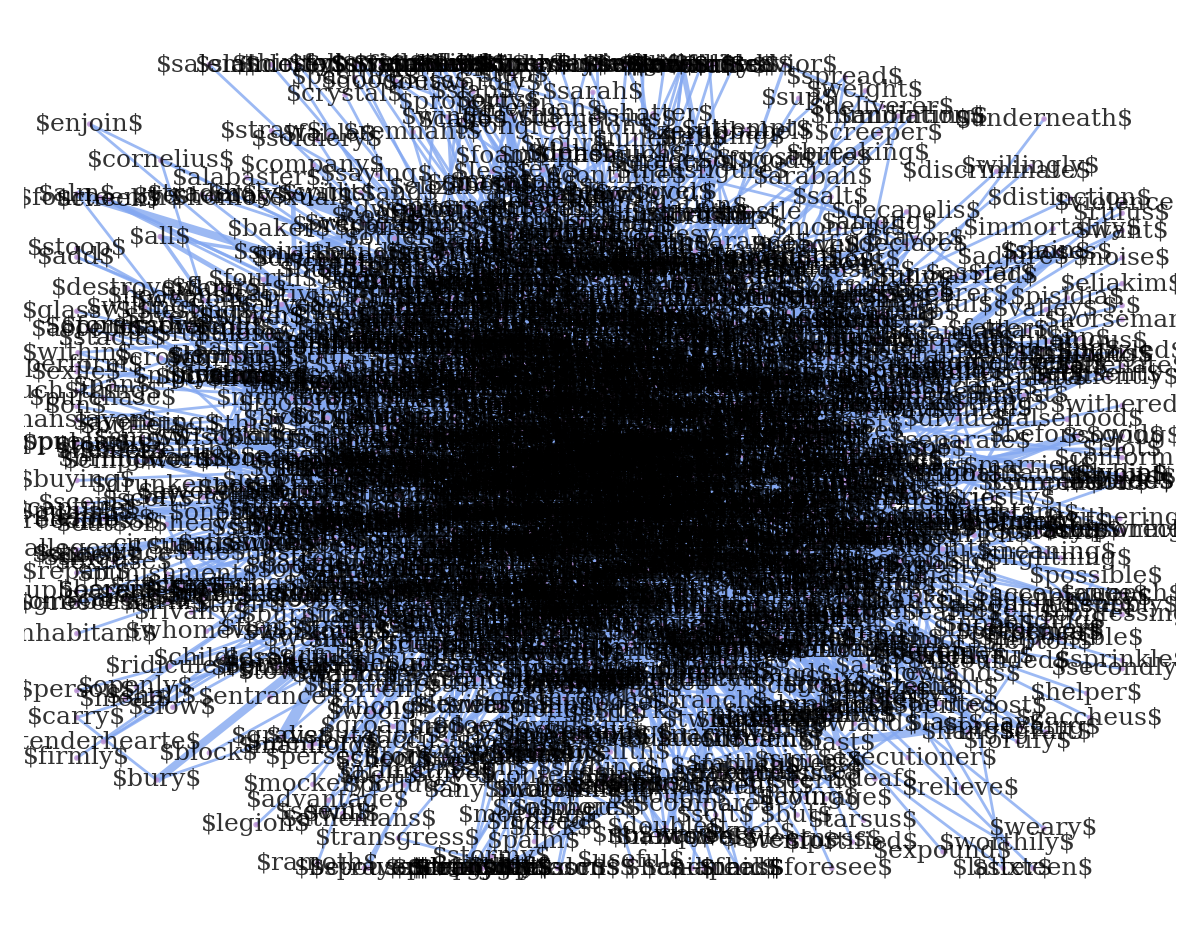

In [22]:
# As most of the communities are meaningful cluster of concepts, to facilitate,
# we might be more interested in LARGE communites
# in the following we visualize communites with more than 10 concepts

for p, nodes in sorted(partition_dict.items(), key=lambda x: x[0], reverse=False):
    if len(nodes) >= number_of_nodes:
        print(f"Community #{p}: {nodes}")
        draw_community(p, partition_dict, undirected_net, save_path=f"./community_figures/{number_of_nodes}/community{p}.pdf")